<a href="https://colab.research.google.com/github/Spocklight/Fake_News_Detection/blob/master/Master_MLFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Detección de noticias falsas</center></h1>
<h3><center>Alejandro Sierra Fernández</center></h3>
<h4><center>01/08/2022</center></h4>

*   <h2>Productivización del modelo</h2>

<font color='darkblue'> En este Notebook vamos a poner un ejemplo sobre cómo productivizar el algoritmo RandomForest. Hemos elegido este algoritmo porque es el que mejor resultados nos ha dado a lo largo del estudio y por su simpleza en comparación con las redes neuronales. A pesar de que habíamos realizado ajuste de parámetros (RandomSearchCV) para encontrar aquellos más óptimos, en este caso vamos predecir empleando diferentes combinaciones de parámetros para ver las distintas métricas que se obtienen.</font>

<font color='darkblue'>Empleamos la herramienta de Opensource *MLFLOW* para gestionar el ciclo de vida de los modelos, registrando los resultados y parámetros para poder compararlos y permitiendo el control de versiones.

También hacemos uso de *Ngrok*, que nos permitirá exponer a internet una URL generada dinámicamente y que apunta a un servicio web que se está generando en nuestra máquina local</font>

<font color='darkblue'>Empezamos instalando e importando MLFlow</font>

In [1]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

     |████████████████████████████████| 16.9 MB 8.0 MB/s 
     |████████████████████████████████| 147 kB 44.9 MB/s 
     |████████████████████████████████| 209 kB 58.0 MB/s 
     |████████████████████████████████| 79 kB 10.1 MB/s 
     |████████████████████████████████| 181 kB 60.0 MB/s 
     |████████████████████████████████| 77 kB 7.9 MB/s 
     |████████████████████████████████| 78 kB 9.4 MB/s 
     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 140 kB 58.5 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 59 kB 8.3 MB/s 
     |████████████████████████████████| 745 kB 9.6 MB/s 


<font color='darkblue'> Configuramos el experimento en el que deseamos trabajar y le damos nombre</font>

In [2]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment(experiment_name="mlflow demo2")

2022/09/22 09:54:26 INFO mlflow.tracking.fluent: Experiment with name 'mlflow demo2' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/1', creation_time=1663840466888, experiment_id='1', last_update_time=1663840466888, lifecycle_stage='active', name='mlflow demo2', tags={}>

Ahora importamos las librerías necesarias para procesar los datos y para definir y entrenar nuestro modelo. Tambié importamos Ngrok

In [3]:
from pyngrok import ngrok

In [4]:
import scipy as sp
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
!mlflow

Usage: mlflow [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  artifacts    Upload, list, and download...
  azureml      Serve models on Azure ML.
  db           Commands for managing an MLflow...
  deployments  Deploy MLflow models to custom...
  experiments  Manage experiments.
  gc           Permanently delete runs in the
               `deleted` lifecycle stage.

  models       Deploy MLflow models locally.
  pipelines    Run MLflow Pipelines and inspect...
  run          Run an MLflow project from the...
  runs         Manage runs.
  sagemaker    Serve models on SageMaker.
  server       Run the MLflow tracking server.
  ui           Launch the MLflow tracking UI
               for...


<font color='darkblue'> Cargamos la información del Drive y la procesamos.</font>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Fake_News/'
pickle_in = open(path + 'ISOT_topic_sentiment_pickle', 'rb')
ISOT = pickle.load(pickle_in)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train, test = train_test_split(ISOT, test_size=0.2, random_state=25)
print(train.shape)
print(test.shape)

(30607, 28)
(7652, 28)


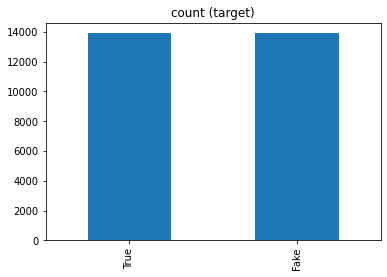

In [9]:
count_1, count_0 = train["target"].value_counts()

class_0 = train[train.target=='Fake']
class_1 = train[train.target=='True']
class_1_under = class_1.sample(count_0)
train_under = pd.concat([class_1_under, class_0], axis=0)

train_under['target'].value_counts().plot(kind='bar', title='count (target)')
train_under['target'].value_counts()
train = train_under

In [10]:
train["target"] = (train['target'] == 'True').astype(np.float32)  #True=1, Fake=0
test["target"] = (test['target'] == 'True').astype(np.float32)  #True=1, Fake=0

In [11]:
vectorizador = TfidfVectorizer(max_features=100,                  
                               ngram_range=(1,3),
                               min_df=10,
                               max_df=0.50,
                               lowercase=False)

vector_title_train = vectorizador.fit_transform(train["clean_title"])
vector_text_train = vectorizador.fit_transform(train["clean_text"])
vector_title_test = vectorizador.fit_transform(test["clean_title"])
vector_text_test = vectorizador.fit_transform(test["clean_text"])

In [12]:
extra_features_train_d = train[['Sentimiento_text', 'Análisis_text', 'Subjetividad_text', 'Sentimiento_title', 'Análisis_title', 'Subjetividad_title', 'topic_modelling_max',
                              'prop_long_text', 'prop_long_title', 'prop_uppercase_text', 'prop_uppercase_title', 'token_title_len', 'token_text_len',
                              'char_len_title', 'char_len_text']]

extra_features_test_d = test[['Sentimiento_text', 'Análisis_text', 'Subjetividad_text', 'Sentimiento_title', 'Análisis_title', 'Subjetividad_title', 'topic_modelling_max',
                              'prop_long_text', 'prop_long_title', 'prop_uppercase_text', 'prop_uppercase_title', 'token_title_len', 'token_text_len',
                              'char_len_title', 'char_len_text']]

sc = StandardScaler()
extra_features_train = sc.fit_transform(extra_features_train_d)
extra_features_test = sc.transform(extra_features_test_d)

In [13]:
y_train = train["target"].values
X_train_text = sp.sparse.hstack((vector_text_train, extra_features_train),format='csr')
X_train_title = sp.sparse.hstack((vector_title_train, extra_features_train),format='csr')

y_test = test["target"].values
X_test_text = sp.sparse.hstack((vector_text_test, extra_features_test),format='csr')
X_test_title = sp.sparse.hstack((vector_title_test, extra_features_test),format='csr')

In [14]:
X_train_text = X_train_text.toarray()
X_train_title = X_train_title.toarray()
X_test_text = X_test_text.toarray()
X_test_title = X_test_title.toarray()


<font color='darkblue'> Cabe destacar que, siguiendo el mismo proceso, también podríamos haber hecho *pickle* con nuestro modelo ya entrenado y haberle dado como *input* nuevas noticias para lanzar predicciones. Sin embargo, de esta forma estudiamos en el servidor diferentes modelos con las diferentes métricas y resultados. De esta forma estamos simulando lo que podría ser el control de versiones</font>

<font color='darkblue'> Definimos las métricas que vamos a emplear.</font>

In [15]:
def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

<font color='darkblue'> Definimos la función *train_model* y empezamos un* run de MLFlow* en el que serán cargadas las métricas y los parámetros de las diferentes versiones. Además, a la función le damos como entrada el número de nodos y la profundidad para poder generar algoritmos con diferentes combinaciones de parámetros y diferentes resultados.</font>

In [16]:
from sklearn.ensemble import RandomForestClassifier


def train_model(max_depth, n_estimators):
  with mlflow.start_run():
    RF_tuned=RandomForestClassifier(criterion = 'gini', max_depth = max_depth, n_estimators = n_estimators)
    RF_tuned.fit(X_train_text,y_train)

    print('Modelo entrenado')

    y_pred = RF_tuned.predict(X_test_text)

    from sklearn.metrics import accuracy_score
    model_accuracy = accuracy_score(y_test, y_pred)
    print(model_accuracy)

    (rmse, mae, r2) = eval_metrics(y_test, y_pred)
#Cargamos las métricas
    mlflow.log_metric("accuracy", model_accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(RF_tuned, "model")

  get_ipython().system_raw("mlflow ui --port 5000 &")   #El siguiente bloque de código abre desde colab una url port 5000
  from pyngrok import ngrok                             
  ngrok.kill()
  # Obtener authtoken de https://dashboard.ngrok.com/auth
  NGROK_AUTH_TOKEN = "2F6P0aUCJURTnlTm1Ak5yn3GhWP_2cbM1JToMZRHjPayqDzhu"
  ngrok.set_auth_token(NGROK_AUTH_TOKEN)
  ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
  print("MLflow Tracking UI:", ngrok_tunnel.public_url)  #Ngrok nos devuelve la url pública para acceder a los resultados en tiempo real

  #https://stackoverflow.com/questions/61615818/setting-up-mlflow-on-google-colab

<font color='darkblue'> Finalmente llamamos al la función con diferentes combinaciones de parámetros.</font>

In [17]:
train_model(10, 250)
train_model(10, 500)
train_model(25, 250)
train_model(50, 500)

Modelo entrenado
0.98170412963931
MLflow Tracking UI: https://6be2-34-125-173-187.ngrok.io
Modelo entrenado
0.9827496079456352
MLflow Tracking UI: https://43d1-34-125-173-187.ngrok.io
Modelo entrenado
0.9823575535807632
MLflow Tracking UI: https://84e3-34-125-173-187.ngrok.io
Modelo entrenado
0.9826189231573444
MLflow Tracking UI: https://8632-34-125-173-187.ngrok.io
